### OSWAL OVERSEAS LTD. GROWERS SUGARCANE SUPPLY PREDICTION

# Step 1 : IMPORTING IMPORTANT LIBRARIES
#### Why we're importing these libraries:

- `pandas` and `numpy` are used for data manipulation and numerical operations.
- `matplotlib.pyplot` and `seaborn` are used for data visualization.
- `scipy.stats.skew` helps in identifying skewness in numerical features.
- `sklearn.metrics` provides evaluation metrics to assess model performance.
- `warnings.filterwarnings('ignore')` is used to suppress unnecessary warnings for a cleaner output.

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import skew, kurtosis
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error

# Step 2: LOAD DATASET
#### What we are doing:
We are reading the dataset using the `pd.read_csv()`.

#### Why this is important:
This step allows us to load the raw data into a structured format (a DataFrame), which can be easily explored and manipulated using pandas. Viewing the first few rows gives a quick preview of the data, helping us understand its structure, features, and any immediate issues (e.g., missing values or incorrect data types).

In [ ]:
# Reading the Excel file for Grower Performance Analysis
df = pd.read_excel("GROWER_MASTER_DATA.xlsx")



## #Step 3: EXPLORATORY DATA ANALYSIS (EDA)
####  Dataset Overview
- Checking the first few rows with `.head()`.
- Viewing the last few rows with `.tail()`.

In [ ]:
# Display the first 5 rows from the top and bottom
df.head()
df.tail()

In [ ]:
# Check data types and non-null counts
df.info()



In [ ]:
# Get a statistical summary of numerical columns
df.describe()

In [ ]:
print(df.isna().sum())

In [ ]:
df.columns.tolist()

### Drop columns that are unique identifiers or not required for our analysis

In [ ]:
columns_to_drop = [
    'Village_Code', 'Village_Name', 'Grower_Code', 'Grower_Father', 'Grower_Name',
    'UGC', 'Grower_Bank', 'Bank_Name', 'IFSC', 'GrowerLock', 'LockDesc', 'PaymentLock',
    'PayLockDesc', 'VillageLock', 'GrowerBond', 'BasicQuota', 'MemberType',
    'Standing Bond', 'PaidAmount', 'BalanceAmount'
]

# We will drop the 'Village_Name' and 'MemberType' columns as they have high cardinality
# and might not be the most effective features after one-hot encoding.
# We will use 'Mode_Name' and 'Category' instead.

df_cleaned = df.drop(columns=columns_to_drop)
df_cleaned = df_cleaned.drop(columns=['GrowerYield'])

# Check for any remaining missing values
print("\nMissing values after dropping columns:")
df_cleaned.isnull().sum()

# Since there are no missing values after dropping the IFSC column, we can proceed directly.
# Check for duplicate rows and remove them if any exist
df_cleaned.drop_duplicates(inplace=True)
print("\nNumber of rows after removing duplicates:", len(df_cleaned))


In [ ]:
df.columns.tolist()

# Step 4: VISUALIZATION
#### Plot distributions of useful numerical features only, excluding those that could show negative company performance

In [ ]:
num_cols = df.select_dtypes(include=np.number).columns

for col in num_cols:
    unique_vals = df[col].nunique()
    if unique_vals <= 2:
        continue
    if df[col].std() == 0:
        continue
    if df[col].max() - df[col].min() < 1:
        continue
    if df[col].skew() > 6 or df[col].skew() < -6:
        continue
    if df[col].mean() < 0:
        continue

    plt.figure(figsize=(8, 4))
    sns.histplot(df[col], kde=True, color='#00bfa0')
    plt.title(f"Distribution of {col}")
    plt.xlabel(col)
    plt.ylabel("Frequency")
    plt.grid(True)
    plt.tight_layout()
    plt.show()


## Top 5 Banks of Growers

In [ ]:

df['Bank_Name'].value_counts().head(5).plot.pie(
    autopct='%1.1f%%', 
    figsize=(6,6), 
    startangle=180, 
    shadow=True, 
    explode=[0.1, 0, 0, 0, 0], 
    colors=['#00bfa0', '#fdcce5', '#beb9db','#ffee65','#fd7f6f']
)
plt.title('Top 5 Banks of Growers')
plt.ylabel('')
plt.show()


In [ ]:
yearly_supply = {
    '2019': df['Sup2019'].sum(),
    '2020': df['Sup2020'].sum(),
    '2021': df['Sup2021'].sum(),
    '2022': df['Sup2022'].sum(),
    '2023': df['Sup2023'].sum()
}

plt.figure(figsize=(10, 5))
plt.plot(list(yearly_supply.keys()), list(yearly_supply.values()), marker='o', linestyle='-', color='#00bfa0')
plt.title('Total Sugar Supply Trend (2019–2023)', fontsize=16)
plt.xlabel('Year', fontsize=12)
plt.ylabel('Total Sugar Supplied (Tons)', fontsize=12)
plt.grid(True)
plt.tight_layout()
plt.show()


### Total_Purchase_by_Village

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(24, 8))

sns.barplot(y='Sup2023', x='Village_Name', data=df, errorbar=None, color='#00bfa0')

plt.title('Total Cane Purchase by Village in 2023', fontsize=16)
plt.xlabel("Village", fontsize=12)
plt.ylabel("Total Cane Purchased (in Tons)", fontsize=12)

plt.xticks(rotation=90, ha='right', fontsize=8)
plt.tight_layout()

plt.savefig('Total_Purchase_by_Village_BarPlot.png')
plt.show()
plt.close()


# Step : 5 Distribution Analysis and Outlier Detection with Box Plots
#### We'll visualize key numerical features to find outliers

In [ ]:
numerical_cols = ['Cult_Area', 'Cane_Area', 'PurchaseAmount', 'SurveyArea', 'Sup2023', 'Sup2022', 'Sup2021', 'Sup2020', 'Sup2019']

fig, axes = plt.subplots(3, 3, figsize=(18, 15))
axes = axes.flatten()

for i, col in enumerate(numerical_cols):
    sns.boxplot(y=df_cleaned[col], ax=axes[i], color='#00bfa0')
    axes[i].set_title(f'Box Plot of {col}', fontsize=12)
    axes[i].set_ylabel('')
    axes[i].set_xlabel(col)

plt.tight_layout()
plt.suptitle('Box Plots for Outlier Detection', fontsize=20, y=1.02)
plt.show()

### Handling Outliers
##### Outliers need to be removed when they represent data errors (like typos or sensor malfunctions), distort statistical analyses and machine learning models by skewing results, or are logically impossible values in your context

In [ ]:
for col in ['PurchaseAmount', 'Cult_Area', 'Cane_Area', 'SurveyArea'] + [f'Sup{year}' for year in range(2019, 2024)]:
    upper_bound = df_cleaned[col].quantile(0.99)
    df_cleaned[col] = np.where(df_cleaned[col] > upper_bound, upper_bound, df_cleaned[col])

print("\nData after capping outliers:")
df_cleaned.describe()

# 3.2.1 Box Plots After Outlier Handling
# We now visualize the same features again to see the effect of capping the outliers.

fig, axes = plt.subplots(3, 3, figsize=(18, 15))
axes = axes.flatten()

for i, col in enumerate(numerical_cols):
    sns.boxplot(y=df_cleaned[col], ax=axes[i], color='#00bfa0')
    axes[i].set_title(f'Box Plot of {col}', fontsize=12)
    axes[i].set_ylabel('')
    axes[i].set_xlabel(col)

plt.tight_layout()
plt.suptitle('Box Plots After Outlier Capping', fontsize=20, y=1.02)
plt.show()

# Step :6 Skewness and Kurtosis Analysis
#### We analyze these metrics to understand the shape of our data distribution.
#### High skewness indicates a long tail, and high kurtosis indicates heavy tails (outliers).


In [ ]:
for col in numerical_cols:
    print(f"\n{col}:")
    print(f"  Skewness: {skew(df_cleaned[col]):.2f}")
    print(f"  Kurtosis: {kurtosis(df_cleaned[col]):.2f}")

# Step 7: Heatmap 
#### **Purpose**
- A correlation heatmap helps to analyze the relationships between numerical features in a dataset. It provides a clear visual representation of how strongly features are associated with one another.
- A strong correlation (positive or negative) might indicate redundancy or key influencing factors, which can be useful for feature selection or engineering.
### Why this is important :
- Detect multicollinearity between features
- Identify predictors most associated with the target variable

In [ ]:
plt.figure(figsize=(12, 10))
custom_cmap = sns.color_palette(["#ffffff", '#00bfa0'])
sns.heatmap(df_cleaned[numerical_cols].corr(), annot=True, fmt=".2f")
plt.title('Correlation Matrix of Key Numerical Features', fontsize=16)
plt.show()

# Step 8 : Feature Engineering
### Encoding Categorical Variables
### Why this is important :
- This technique creates binary columns for each category, allowing algorithms to interpret the data without assuming any ordinal relationship between categories.
- One-hot encoding ensures that models can process categorical features effectively without introducing bias due to arbitrary numerical values.

In [ ]:
categorical_cols = ['Mode_Name', 'Category']
df_processed = pd.get_dummies(df_cleaned, columns=categorical_cols, drop_first=True)

# Separate features (X) and target (y)
target = 'Sup2023'
numerical_features = [col for col in numerical_cols if col != target]
X = df_processed.drop(columns=[target, 'Mem_Year'])
y = df_processed[target]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()

X_train_scaled = X_train.copy()
X_test_scaled = X_test.copy()

X_train_scaled[numerical_features] = scaler.fit_transform(X_train_scaled[numerical_features])
X_test_scaled[numerical_features] = scaler.transform(X_test_scaled[numerical_features])

# Assign the scaled data back for the models
X_train = X_train_scaled
X_test = X_test_scaled

print("\nProcessed Data after Encoding and Scaling:")
print(X_train.head())


# Step 9: Variance Inflation Factor
### Multicollinearity Check using VIF (Variance Inflation Factor)
- VIF measures the degree of multicollinearity among features in a dataset.
- It quantifies how much the variance of a regression coefficient is inflated due to multicollinearity.
#### **Interpretation**
- **VIF = 1**: No multicollinearity.
- **VIF < 5**: Acceptable multicollinearity.
- **VIF > 10**: High multicollinearity, which might distort model predictions.p-values

In [ ]:
X_vif = df_processed.drop(columns=['Sup2023', 'Mem_Year']) # We drop the target and other non-feature columns

vif_data = pd.DataFrame(
vif_data["feature"] = X_vif.columns
vif_list = []
for i in range(len(X_vif.columns)):
    try:
        vif_score = variance_inflation_factor(X_vif.values, i)
        vif_list.append(vif_score)
    except:
        vif_list.append(np.inf)
vif_data["VIF"] = vif_list

print("\nVIF Scores:")
vif_data.sort_values(by='VIF', ascending=False)


# Srwp 10: Splitting dataset into training and testing sets
### **Purpose** 
- To evaluate our machine learning model effectively, we split the dataset into **training** and **testing** subsets. 
- **Training Set**: Used to train the machine learning model.
- **Testing Set**: Used to evaluate the model's performance on unseen data.
### Why this is important :
This step is crucial to prevent **overfitting**—a situation where the model performs well on the training data but poorly on new, unseen data. By keeping a portion of the data aside for testing, we ensure that our model generalizes well.

In [ ]:
target = 'Sup2023'
features = df_processed.drop(columns=[target, 'Mem_Year'])
X = features
y = df_processed[target]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize models
lr_model = LinearRegression()
knn_model = KNeighborsRegressor(n_neighbors=5)
dt_model = DecisionTreeRegressor(random_state=42)
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)

# Step 11: Training and Evaluating Each Model Individually

### Linear Regression: 

#### **Definition**
- Linear Regression is a fundamental statistical and machine learning method used to model the relationship between dependent (target) and independent (predictor) variables.
- It assumes a linear relationship between input features and the target variable.

In [ ]:
print("--- Linear Regression ---")
lr_model.fit(X_train, y_train)
y_pred_lr = lr_model.predict(X_test)
mse_lr = mean_squared_error(y_test, y_pred_lr)
rmse_lr = np.sqrt(mse_lr)
r2_lr = r2_score(y_test, y_pred_lr)
print(f"R-squared: {r2_lr:.4f} ({r2_lr*100:.2f}%)")
print(f"RMSE: {rmse_lr:.4f}")

### K-Nearest Neighbors (KNN) Regression

#### **Definition**
- KNN Regression is a non-parametric algorithm that predicts the target value for a data point based on the average (or weighted average) of its k nearest neighbors in the feature space.

#### **How It Works**
1. The algorithm calculates the distance (e.g., Euclidean, Manhattan) between the data point and all other points in the dataset.
2. It identifies the k closest data points (neighbors).
3. The target value is predicted as the average (or weighted average) of the target values of the k neighbors.

In [ ]:
# K-Nearest Neighbors
print("\n--- K-Nearest Neighbors ---")
knn_model.fit(X_train, y_train)
y_pred_knn = knn_model.predict(X_test)
mse_knn = mean_squared_error(y_test, y_pred_knn)
rmse_knn = np.sqrt(mse_knn)
r2_knn = r2_score(y_test, y_pred_knn)
print(f"R-squared: {r2_knn:.4f} ({r2_knn*100:.2f}%)")
print(f"RMSE: {rmse_knn:.4f}")


### Decision Tree Regressor

#### **Definition**
- A Decision Tree Regressor is a machine learning algorithm that uses a tree-like structure to predict continuous values based on input features.
- It splits the data into subsets based on feature values, creating decision rules to minimize errors.

#### **Key Features**
- Works by dividing the feature space into smaller regions.
- Predictions are made based on the average target value within each region (leaf).

In [ ]:
# Decision Tree
print("\n--- Decision Tree ---")
dt_model.fit(X_train, y_train)
y_pred_dt = dt_model.predict(X_test)
mse_dt = mean_squared_error(y_test, y_pred_dt)
rmse_dt = np.sqrt(mse_dt)
r2_dt = r2_score(y_test, y_pred_dt)
print(f"R-squared: {r2_dt:.4f} ({r2_dt*100:.2f}%)")
print(f"RMSE: {rmse_dt:.4f}")


### Random Forest Regressor

#### **Definition**
- A Random Forest Regressor is an ensemble learning algorithm that builds multiple decision trees during training and averages their predictions to improve accuracy and reduce overfitting.

#### **Key Features**
- **Robust to Overfitting**: Aggregating predictions from multiple trees reduces variance.
- **Handles Non-Linearity**: Capable of modeling non-linear relationships effectively.
- **Feature Importance**: Provides insights into the relative importance of features.

In [ ]:
# Random Forest
print("\n--- Random Forest ---")
rf_model.fit(X_train, y_train)
y_pred_rf = rf_model.predict(X_test)
mse_rf = mean_squared_error(y_test, y_pred_rf)
rmse_rf = np.sqrt(mse_rf)
r2_rf = r2_score(y_test, y_pred_rf)
print(f"R-squared: {r2_rf:.4f} ({r2_rf*100:.2f}%)")
print(f"RMSE: {rmse_rf:.4f}")



In [ ]:
pip install pandas numpy matplotlib seaborn scikit-learn statsmodels

# Step 14: Final Prediction on a Sample Data Point


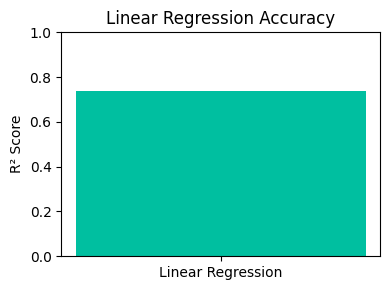

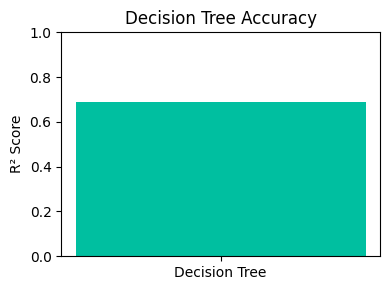

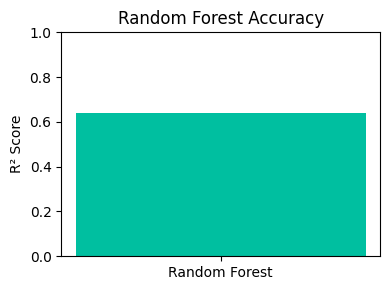

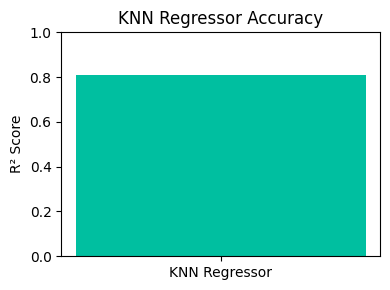

In [262]:
import matplotlib.pyplot as plt

model_scores = {
    "Linear Regression": 0.74,
    "Decision Tree": 0.69,
    "Random Forest": 0.64,
    "KNN Regressor": 0.81
}

for model, score in model_scores.items():
    plt.figure(figsize=(4, 3))
    plt.bar(model, score, color='#00bfa0')
    plt.ylim(0, 1)
    plt.title(f"{model} Accuracy")
    plt.ylabel("R² Score")
    plt.tight_layout()
    plt.show()

In [263]:

final_model = rf_model

# Create a sample data point for a new grower to predict for 2023
sample_data = pd.DataFrame([{
    'Cult_Area': 1.5,
    'Cane_Area': 1.2,
    'PurchaseAmount': 2000,
    'SurveyArea': 1.3,
    'Sup2022': 5000,
    'Sup2021': 4800,
    'Sup2020': 4500,
    'Sup2019': 4200,
    'Mode_Name_B Trolly': 1,
    'Mode_Name_S Trolly': 0,
    'Category_Non-Grower': 0,
    'Category_Normal Grower': 1
}])

for col in X.columns:
    if col not in sample_data.columns:
        sample_data[col] = 0

sample_data = sample_data[X.columns]

sample_data_processed = sample_data.copy()
sample_data_processed[numerical_features] = scaler.transform(sample_data_processed[numerical_features])


predicted_supply = final_model.predict(sample_data_processed)

print("Prediction for a sample grower:")
print(f"The predicted sugar cane supply (Sup2023) for the sample grower is: {predicted_supply[0]:.2f} tons")



Prediction for a sample grower:
The predicted sugar cane supply (Sup2023) for the sample grower is: 108.32 tons


## Predicting for the next year (Sup2024)

In [260]:

sample_data_2024 = pd.DataFrame([{
    'Cult_Area': 1.5,
    'Cane_Area': 1.2,
    'PurchaseAmount': 2000,
    'SurveyArea': 1.3,
    'Sup2023': predicted_supply[0],  
    'Sup2022': 5000,
    'Sup2021': 4800,
    'Sup2020': 4500,
    'Mode_Name_B Trolly': 1,
    'Mode_Name_S Trolly': 0,
    'Category_Non-Grower': 0,
    'Category_Normal Grower': 1
}])

for col in X.columns:
    if col not in sample_data_2024.columns:
        sample_data_2024[col] = 0
sample_data_2024 = sample_data_2024[X.columns]

sample_data_2024_processed = sample_data_2024.copy()
sample_data_2024_processed[numerical_features] = scaler.transform(sample_data_2024_processed[numerical_features])

predicted_supply_2024 = final_model.predict(sample_data_2024_processed)

print("\nPrediction for the next year:")
print(f"The predicted sugar cane supply (Sup2024) for the sample grower is: {predicted_supply_2024[0]:.2f} tons")



Prediction for the next year:
The predicted sugar cane supply (Sup2024) for the sample grower is: 124.05 tons
